In [1]:
# This cell is just to remove some very annoying but inconsequential warning messages
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [2]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions

## Generalized example

exp( - (xhat-x)^2/2 - (yhat-m x)^2/2)  

In [3]:
# The (single!) data point:
npts = 1

xhat=10.0
yhat=15.0
data = jnp.array([xhat, yhat])

In [4]:
def log_prob(x, m):

  # Posterior is a product of Gaussians, centred on (x,mx).  Combine them into a vector (this isn't strictly necessary - 
  # two separate gaussians would do):
  centre = x * jnp.array([1, m])

  # Gaussian likelihood centred there:
  likelihood = tfd.MultivariateNormalDiag(loc=centre, scale_identity_multiplier=1.0)

  # Adding some priors on m and x:
  # prior_x = tfd.MultivariateNormalDiag(loc=jnp.zeros(npts), scale_identity_multiplier=0.1)
  prior_x = tfd.Normal(loc=0., scale=10.0)
  # Wide gaussian prior on m:
  prior_m = tfd.Normal(loc=0., scale=10.0)

  return likelihood.log_prob(data)  + prior_x.log_prob(x) + prior_m.log_prob(m)

In [5]:
# Initialize the HMC transition kernel.
num_results = int(1e6)             # How many ouputs we want, will include rejected proposals as well
num_burnin_steps = int(1e4)         # How many burn-in steps

# This defines an HMC kernel, wrapped around a simple step-size adaptation
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=log_prob,
                num_leapfrog_steps=3,
                step_size=0.01) # Step size can be automatically adjusted in more complex examples

In [6]:
# Run the chain (with burn-in).
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[5.0,0.0],  # Where to start the chain
      kernel=hmc_kernel,
      seed=jax.random.PRNGKey(42),          # Random seed used in all stochastic calls 
      trace_fn=lambda _, pkr: pkr.is_accepted) # This trace function is optional, it chooses what info to keep in the output of the sampler

In [7]:
jnp.mean(is_accepted)

DeviceArray(0.999742, dtype=float32)

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'm')

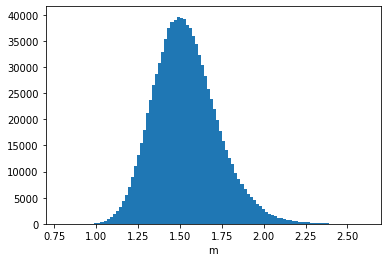

In [8]:
%pylab inline 
# Plotting distributions of offset parameter x
#hist(samples[1][is_accepted][:, 0])
hist(samples[1][is_accepted],bins=100)
xlabel('m')

Text(0.5, 0, 'x')

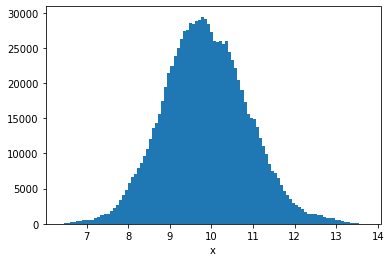

In [9]:
# Plotting distributions of scale parameter m
hist(samples[0][is_accepted],bins=100)
xlabel('x')

Text(0, 0.5, 'm')

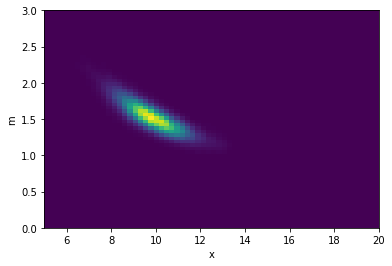

In [12]:
# Joint posterior for x and m:
hist2d(samples[0][is_accepted], samples[1][is_accepted], 64, range=[[5,20], [0,3]]); 
xlabel('x')
ylabel('m')

In [11]:
# Add PPD